In [ ]:

import pandas as pd
import numpy as np
np.random.seed(0)

import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt

## Exercise 1 (6 pt)

In [2]:
def loss(x, y, w, l):
    # x is a n \times d matrix, y is a vector
    return np.sum((y - x.dot(w))**2 / 2) + (l / 2) * np.sum(np.abs(w))

**Question 1 (1 pt)** What loss, seen in class, is computed by the function `loss` ? 

_Answer_ :
This specific loss function we see in the code corresponds mathematically to:

\begin{equation}
 \mathcal{L}(w) = \frac 12 \sum_{i=1}^n (y_\mu - X_{\mu i} w_i)^2 + \frac \lambda 2 \sum_{i=1}^d |w_i|
\end{equation}

It is a combination of two terms, a sum of squares (linear regression loss) and the lasso penalty ($\ell_1$ regularization).

* The first term $\frac 12 \sum_{i=1}^n (y_\mu - X_{\mu i} w_i)^2$ is the **linear regression loss** or mean square error (MSE). This loss accounts for the difference between the output labels $y\in \mathbb{R}^n$ (vector) and the predicted values $X\cdot w$, where $X\in \mathbb{R}^{n\times d}$ is the input data matrix, and $w \in \mathbb{R}^n$ is the weights to learn.

* The second term $\frac \lambda 2 \sum_{i=1}^d |w_i|$ is a $\ell_1$ regularization term or **LASSO penalty (least absolute shrinkage and selection operator)**, where we introduce $\lambda$ here as a regularization strength for our penalty. 

**Explain in what contexts it is used, compared to other losses.**

This is a **LASSO Regression loss function**, and is generally used for sparse linear regression for variable selection by making weights tend to zero. Compared to ordinary least squares, its similar, but includes regularization to penalize large coefficients. We minimize the function to achieve minimal loss during regression tasks and the regularization increases accuracy and intepretation of the model. We include the penalty from the norm on the weights through the second term. By adding a pentaly, we make this a form of sparse regression, where some unfavourable weights $w_i$ tend to zero $\to$ removes features that are not strictly helpful for our prediction. This has further importance in variable selection and interpretation of estimated weights $\hat w$. It makes it possible to select among variables of the problem that are relevant for a most accurate prediciton. Opposite to ridge regression, it can set coefficients to zero. If you have a few set of defining features that are important in our dataset, the LASSO regression is the clear winner here. 



In [3]:
def ridge_estimator(x, y, l):
    n, d = x.shape
    return np.linalg.inv((x.T @ x + l * np.eye(d))) @ x.T @ y

**Question 2 (1 pt)** We want the function `ridge_estimator` defined above to compute the estimator that minimizes the Ridge loss. Is there any mistake in this code ? If yes, fix it.

_Answer_ : The original code was defined as

\begin{equation}
    \hat w = (X^TX + \lambda \mathbb{I}) X^Ty
\end{equation}

It is close to correct, but is missing a crucial step, which is inverting the product, such that we should instead have

\begin{equation}
    \hat w = (X^TX + \lambda \mathbb{I})^{-1} X^Ty
\end{equation}

In [4]:
def gradient_descent(x, y, B):
    """
    arguments:
        x -- n x d matrix
        y -- n vector
        B -- integer
    """
    # compute an estimator using gradient descent
    n, d = x.shape
    w = np.zeros(d)
    tolerance = 1e-3
    diff = np.inf

    eta = 0.1
    
    while diff > tolerance:
        w_old = np.copy(w)

        indices = np.random.choice(n, B)
        x_batch = x[indices]
        y_batch = y[indices]
        
        w -= eta * np.dot(x_batch.T, np.dot(x_batch, w) - y_batch)

        diff = np.sum((w_old - w)**2) / d
    return w

**Question 3 (2 pt)** The goal of the function `gradient_descent` is to compute an estimator using stochastic gradient descent.

a) What is the value of the regularization here ? 

_Answer_ : There is no regularization term here, such that the value of the regularization is $\lambda = 0$, for $\ell_2$ regularization, we would need to add the gradient of the regularization (here `l * w`) to the update rule for example.

b) Explain the role of the variable `eta`. 

_Answer_ : `eta` / $\eta$ is the learning rate or step size. It is a parameter that we tune till our liking. If $\eta$ is too small, we will converge too slow towards the minima, and computing the gradient here becomes computationally expensive. If $\eta$ is too large, it is possible to miss a minima of the loss function, causing at further iterations to diverge. This is precisely a trade-off between convergence and 'overshooting'

c) What line(s) would you change (and how) to perform gradient descent instead of stochastic gradient descent ?

_Answer_ : 
We would change the line from `w -= eta * np.dot(x_batch.T, np.dot(x_batch, w) - y_batch)` to
 `eta * np.dot(x.T, (np.dot(x,w) - y))`, where we perform the gradient on the entire set `x` and `y`, instead of picking out random batches. We can thus discard the lines `x_batch`, `y_batch` and `indices` as well. Mathematically the vector equation is essentially the same, where now we need to perform normal gradient descent, we need that $\forall i \in \{1,\dots,d \}$ the $i$-th weight $w_i$ at iteration $t+1$, we have

\begin{equation}
    w_{i}^{t+1} = w_i^t - \eta \frac{\partial \mathcal L (\vec w)}{\partial w_i}\Bigg |_{\vec w^t}
\end{equation}



**Question 4 (2 pt)** In the function `gradient_logistic_l2`, implement the gradient of the following loss (as before, we use here labels equal to $\pm 1$) :
$$
    \mathcal{L}(\vec{w}) = \frac{1}{n} \left( \sum_{i = 1}^n \log \left( 1 + e^{- y_i \times \vec{w}^{\top} \vec{x}_i} \right) + \frac{\lambda}{2} \| \vec{w} \|^2 \right)
$$

_Answer_ :

$$
\frac{\partial \mathcal L}{\partial w} = - \frac 1n \sum_{i=1}^n y_i x_i \left(1-\frac{1}{1+exp(-y_i \cdot w^Tx_i)}\right)+\lambda w, \hspace{0.5cm} \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [5]:
def gradient_logistic_l2(w, X, y, l):
    # your code here 
    n, d = np.shape(X)
    z = y * (X @ w)
    sigmoid = 1 / (1 + np.exp(-z))  # Sigmoid function
    gradient = -(1/n) * (X.T @ (y * (1 - sigmoid))) + (l * w) # gradient of the loss
    return gradient

## Exercise 2 (10 pt)

In this exercise, we will perform linear classification on the SUSY dataset. Here, each data sample corresponds to particle collision event, which will be either from background noise (label `0`) or a supersymmetric event (label `1`). The input is made of $18$ numerical features related to the collision.

Because the original dataset is quite large (more than 1 GB), we will work with a small version of it containing 10000 training samples, that you can download on the Moodle page, called `susy_small.csv`.

### Data preparation

First, we will clean the data to make it more convenient to work with.
**Question 1 (1 pt)** a) Implement the function `load_dataset` to return two numpy arrays `x` and `y`. `y` must contain the values in the column `SUSY` of the dataframe `df`, while `x` contains the rest of the data.

In [6]:
def load_dataset():
    df = pd.read_csv('susy_small.csv')
    # TODO your code here 
    x = df.iloc[1:, 1:].values # all the data except column SUSY (also skip header)
    y = df.iloc[1:, 0].values # column SUSY (0.0 or 1.0)
    return x, y

b) Observe the values taken by the labels $y$. Transform them such that they are either $-1$ or $1$ to be coherent with the notation seen in class.

In [7]:
def label_to_pm_one(y):
    x, y = load_dataset()
    y_new = np.where(y == 0, -1, 1) # If y=0 then y=-1 otherwise if y=1 then y=+1
    return y_new

**Question 2 (1 pt)** As good practice, it is preferable to have normalized data that is to say that the mean of the input matrix `X` accross its first first dimension should be $0$, and its variance should be $1$. This is not the case here. We then want to write a function that does two things : 1) split the data into training and validation sets and 2) normalize the training data. 

Here are two possible functions, `function1` and `function2` written for this purpose. Which of them is preferrable to the other and why ? 

_Reminder_ : The function `sklearn.model_selection.train_test_split` splits a given dataset `X`, `y` into a training and test data. The role of  the argument `random_state=0` is for reproducibility purposes.

_Answer_ : In practice, it is obvious that `function1` is more preferrable. It is important to note that we want to normalize the **training data**, so we want to use the mean and variance only from the training set. `function1` calculates only the mean and variance from the training set, whereas `function2` calculates the mean and variance for the entire dataset before splitting into training and validation. The reason why its preferable to calculate the mean and variance from the training set is to avoid overfitting and statistical biases. So therefore `function1` **is more preferrable** since it will give a more realistic model that is not overfitted, unlike `function2`.

In [8]:
def function1(x, y):
    # First split into training and validation, then compute the mean and variance of training data to normalize
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    mean_x_train = np.mean(x_train, axis = 0)
    var_x_train  = np.var(x_train, axis = 0)
    x_train = (x_train - mean_x_train) / np.sqrt(var_x_train)
    x_test  = (x_test  - mean_x_train) / np.sqrt(var_x_train)
    return x_train, x_test, y_train, y_test

def function2(x, y):
    # First compute the mean and variance of data, then split into training and validation
    mean_x = np.mean(x, axis = 0)
    var_x  = np.var(x, axis = 0)
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    x_train = (x_train - mean_x) / np.sqrt(var_x)
    x_test  = (x_test  - mean_x) / np.sqrt(var_x)
    return x_train, x_test, y_train, y_test

function_normalize = function1
# function_normalize = function2

### Logistic regression

**Question 4 (4 pt)** We want to run two methods to clasify the data : logistic regression with $\ell_1$ and $\ell_2$ penalty. 

a) First, implement the functions `logistic_l2` and `logistic_l1` that compute and returns the estimator for their corresponding losses. To this end, use the `sklearn.linear_model.LogisticRegression` class with the appropriate choice of penalty.

_Important note_ : in the initialization of `LogisticRegression`, set the argument `solver='liblinear'` to avoid an error.

In [9]:
def logistic_l1(x, y, l):
    logreg = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, C=1.0/l)
    return logreg.fit(x, y)

def logistic_l2(x, y, l):
    logreg = lm.LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000,  C=1.0/l)
    return logreg.fit(x, y)

b) Implement the functions `logistic_l2_crossvalidation` and `logistic_l1_crossvalidation` that compute the accuracy on the _validation data_ of the estimators trained for different values of $\lambda$ : for a list `lambda_range` that contains a list of the $\lambda$ to be tested, the function should return another list of the same length that contains the accuracy for each $\lambda$.

In [10]:
def logistic_l1_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    accuracies = np.zeros(len(lambda_range))
    for i, l in enumerate(lambda_range):
        logreg = logistic_l1(x_train, y_train, l)
        accuracies[i] = logreg.score(x_val, y_val) # Compute accuracy on validation set
    return accuracies

def logistic_l2_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    accuracies = np.zeros(len(lambda_range))   
    for i, l in enumerate(lambda_range):
        logreg = logistic_l2(x_train, y_train, l) # Train l2 logistic regression
        accuracies[i] = logreg.score(x_val, y_val)  # Compute accuracy on validation set
    return accuracies

c) Using the functions of the previous questions, plot the validation accuracy for `lambda_range = np.logspace(-2, 5, 50)` for both $\ell_1$ and $\ell_2$ regularizations (don't hesitate to use a logarithmic scale for the x-axis). What are the optimal values $\lambda_1, \lambda_2$ ? 

_Answer_ : The optimal values for $\lambda_1, \lambda_2$, are the ones that have the highest accuracy for a given range of $\lambda$. This is done matematically by optimizing the cost function, but in this case by cross-validation. For each $\lambda$, we train the model on the training data and evaluate its performance of validation data using the `.score` function that calculates the mean accuracy for the trained model vs. validation data.

For the two different penalties we get the best $\lambda_{\ell_1} \approx 1.931$ with $78.55 \% $ validation accuracy and $\lambda_{\ell_2} \approx 1.389$ with $78.4 \%$ validation accuracy


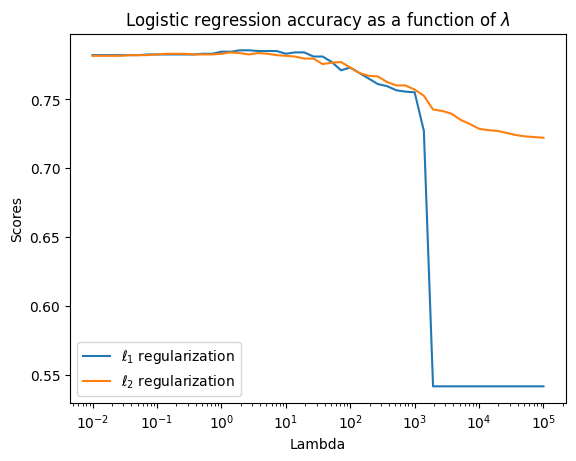

In [11]:
 # 1) load the data and normalize it 
x, y = load_dataset()
x_train, x_test, y_train, y_test = function1(x, y)

# 2) compute the scores for logistic regression with l1 penalty
lambda_range = np.logspace(-2, 5, 50)
scores_l1s = logistic_l1_crossvalidation(x_train, y_train, x_test, y_test, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
scores_l2s = logistic_l2_crossvalidation(x_train, y_train, x_test, y_test, lambda_range)


# 4) plot the scores as a function of lambda_range
plt.title(r"Logistic regression accuracy as a function of $\lambda$")
plt.plot(lambda_range, scores_l1s, label=rf"$\ell_1$ regularization")
plt.plot(lambda_range, scores_l2s, label=rf"$\ell_2$ regularization")

#uncomment to visualize the results
plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.show()

In [12]:
# 5) print the best lambda for l1 and l2 penalties
print("Best lambda for l1:", lambda_range[np.argmax(scores_l1s)])
print("Best lambda for l2:", lambda_range[np.argmax(scores_l2s)])

print("Accuracy l1:", np.max(scores_l1s) * 100, "%")
print("Accuracy l2:", np.max(scores_l2s) * 100, "%")

Best lambda for l1: 1.9306977288832496
Best lambda for l2: 1.3894954943731375
Accuracy l1: 78.55 %
Accuracy l2: 78.4 %


d) When $\lambda$ is big enough, the validation accuracy for $\ell_1$ regularization becomes constant to some value (let's call it $acc_{\infty}$). Justify that $acc_{\infty}$ is equal to the proportion of background events (i.e samples with label $-1$) in the validation data.

_Answer_ : As explained earlier, for $\ell_1$ regularization (LASSO), the weights tend to zero for large enough $\lambda$ since it creates a more sparse model by removing some of the feautures from model. For the linear classification, where the labels $y=-1$ indicates the background events in the validation data, all of the predictions will become $\ell_1$ when all the weights tend to zero, predicting the majority class.

If the regularization strength $\lambda$ is too large, it will effectively remove all the features such that you cannot distinguish different types of classes since the decision boundary effectively becomes flat.

As all weights go to zero $w \to 0 \implies \hat y = \frac{1}{1+e^0} = 0.5$. The threshold $\epsilon$ is set for 0.5 for this type of algorithm such that $\hat y = +1, \epsilon < 0.5$ and $\hat y = -1, \epsilon \leq 0.5$ for all the points. If the validation set contains majority background events labeled $y=-1$, it will predict even the other class that isn't background as $y=-1$ as $\lambda \to \infty$. The portion of background being the labels $y=-1$ in the validation data will thus give the accuracy $acc_\infty$ as

\begin{equation}
acc_\infty = \frac{\# \text{ correct predictions for y=-1 samples}}{\# \text{ total samples}}
\end{equation}

### Adding interacting polynomial features

In this section, we will try to improve our classifier by adding features in our data, namely the product of the 18 existing features. That is to say, for all pair of indices $0 \leqslant i, j \leqslant 17$ with $i \neq j$ we will add the feature `X[:, i] * X[:, j]` to the matrix `X` (to have 171 features in total).

**Question 5 (1 pt)** Implement the function `add_interactions` to add the features described above.

_Hint_ : You can use a class seen in the exercise session to do so, with the correct arguments `degree` and `interaction_only`. The final dimension should be 171.


In [13]:
def add_interactions(X):
    poly = pp.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_int = poly.fit_transform(X) #interactions with polynomial fetures added to it
    return X_int

X_interactions = add_interactions(x)
print("Final dimension:", np.shape(X_interactions)[1])


Final dimension: 171


**Question 6 (3 pt)** Redo the steps of question 3 and 4 to find the optimal regularization strength $\lambda_{1, poly}$ and $\lambda_{2, poly}$ that correspond to the best validation accuracy. Did the validation accuracy improve compared to question 4 ? 

_NOTE_ : The computation may take some time, so be patient.

_Answer_ : The validation accuracy slightly improved compared to question 4. The validation accuracy increased by approximately $1 \%$, which shows an increase in predictive power, but indicates that we may have to try different methods here. Since the accuracy increased so little, it means that even after adding polynomial features, the model is not able to capture the patterns and classify any significantly better than without polynomial features. 

Some possibilites: It could be that we overfitted/underfitted the training data, and the regularization possibly mitigates this. The data could also be too complex to be of any help with polynomial features. 

Anyways, in this case it is pointless to have almost $70$ times slower algorithm, just to get $1\%$ increment in validation accuracy. The computational complexity for adding polynomial features of degree $p$ is $\mathcal{O}(d^p)$ for $d$ number of features for $X \in \mathbb{R}^{n \times d}$, so it is reasonable to discard this as a potential improvement to our model, and play around and test other methods for improving validation accuracy.

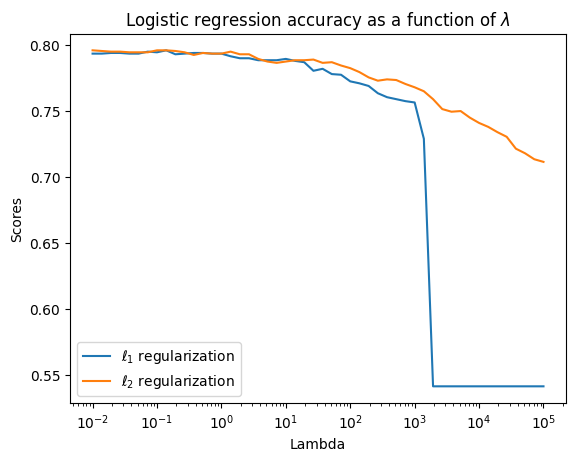

In [14]:
# 1) load the data with interactions now and normalize it 
x_train_int, x_test_int, y_train_int, y_test_int = function1(X_interactions, y)

# 2) compute the scores for logistic regression with l1 penalty
lambda_range = np.logspace(-2, 5, 50)
scores_l1_int = logistic_l1_crossvalidation(x_train_int, y_train_int, x_test_int, y_test_int, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
scores_l2_int = logistic_l2_crossvalidation(x_train_int, y_train_int, x_test_int, y_test_int, lambda_range)

# 4) plot the scores as a function of lambda_range
plt.title(r"Logistic regression accuracy as a function of $\lambda$")
plt.plot(lambda_range, scores_l1_int, label=rf"$\ell_1$ regularization")
plt.plot(lambda_range, scores_l2_int, label=rf"$\ell_2$ regularization")

#uncomment to visualize the results
plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.show()

In [15]:
# 5) print the best lambda for l1 and l2 penalties
print("Best lambda for l1:", lambda_range[np.argmax(scores_l1_int)])
print("Best lambda for l2:", lambda_range[np.argmax(scores_l2_int)])
diff_l1 = (np.max(scores_l1_int)-np.max(scores_l1s))*100
diff_l2 = (np.max(scores_l2_int)-np.max(scores_l2s))*100
# The difference in accuracy
print(f"Interaction terms for l1 added is: {diff_l1:.2f} % more accurate")
print(f"Interaction term for l2 added is: {diff_l2:.2f} % more accurate")

Best lambda for l1: 0.13894954943731375
Best lambda for l2: 0.01
Interaction terms for l1 added is: 1.05 % more accurate
Interaction term for l2 added is: 1.20 % more accurate


### **Bonus for fun**: I tried to optimize cross-validation to make the proccess faster with parallellization

In [16]:
from joblib import Parallel, delayed

def train_model(l, x_train, y_train, x_val, y_val, penalty):
    solver = 'saga' if penalty == 'l1' else 'lbfgs'  # saga solver for l1, lbfgs for l2
    logreg = lm.LogisticRegression(penalty=penalty, C=1/l, solver=solver, max_iter=1000)
    logreg.fit(x_train, y_train)
    accuracy = logreg.score(x_val, y_val)
    return accuracy

def logistic_crossvalidation_parallel(x_train, y_train, x_val, y_val, lambda_range, penalty='l2'):
    accuracies = Parallel(n_jobs=-1)(delayed(train_model)(l, x_train, y_train, x_val, y_val, penalty) for l in lambda_range)
    return np.array(accuracies)

# Example usage for both l1 and l2 regularization
lambda_range = np.logspace(-2, 5, 50)


In [17]:
# 1) load the data with interactions now and normalize it 
x_train_int, x_test_int, y_train_int, y_test_int = function1(X_interactions, y)

# 2) compute the scores for logistic regression with l1 penalty
lambda_range = np.logspace(-2, 5, 50)

# L2 regularization
l2_accuracies = logistic_crossvalidation_parallel(x_train_int, y_train, x_test_int, y_test, lambda_range, penalty='l2')

# L1 regularization
l1_accuracies = logistic_crossvalidation_parallel(x_train_int, y_train, x_test_int, y_test, lambda_range, penalty='l1')

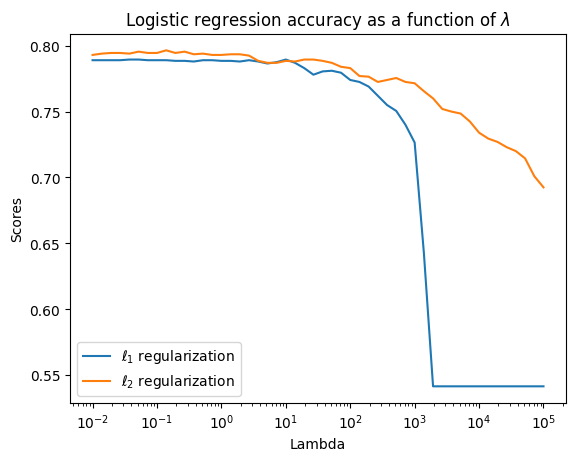

In [18]:
# 4) plot the scores as a function of lambda_range
plt.title(r"Logistic regression accuracy as a function of $\lambda$")
plt.plot(lambda_range, l1_accuracies, label=rf"$\ell_1$ regularization")
plt.plot(lambda_range, l2_accuracies, label=rf"$\ell_2$ regularization")

plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.show()